# Micrograd

micrograd is basically an autograd engine autograd is short for automatic gradient and really what it does is it implements backpropagation

## Back Propagation
 backpropagation is this algorithm that allows you to efficiently evaluate the gradient of some kind of a loss function with respect to the weights of a neural network and what that allows us to do then is we can iteratively tune the weights of that neural network to minimize the loss function and therefore improve the accuracy of the network

### example
micrograph basically allows you to build out mathematical expressions and um here what we are doing is we have an expression that we're building out where you have two inputs a and b.

you'll see that a and b are negative four and two but we are wrapping those values into this value object that we are going to build out as part of micrograd so this value object will wrap the numbers themselves and then we are going to build out a mathematical expression here where a and b are transformed into c d and eventually e f and g.

so it will for example know that c is also a value c was a result of an addition operation and the child nodes of c are a and b and will maintain pointers to a and b value objects.

so we'll basically know exactly how all of this is laid out and then not only can we do what we call the **forward pass** where we actually look at the value of g, but the big deal is that we can also take this g value object and we can call **backward** and this will basically uh initialize back propagation at the node g.

what backpropagation is going to do is it's going to start at g and it's going to go backwards through that expression graph and it's going to recursively apply the chain rule from calculus and what that allows us to do then is we're going to evaluate basically the derivative of g with respect to all the internal nodes like e d and c but also with respect to the inputs a and .

this derivative we'll see soon is very important information because it's telling us how a and b are affecting g. so in here a dot grad is 138 so if we slightly nudge a and make it slightly larger 138 is telling us that g will grow and the slope of that growth is going to be 138 and the slope of growth of b is going to be 645. so that's going to tell us about how g will respond if a and b get tweaked a tiny amount in a positive direction.

one more note i would like to make at this stage, is that as you see here micrograd is a scalar value auto grad engine so it's working on the level of individual scalars like negative four and two and we're taking neural nets and we're breaking them down all the way to these atoms of individual scalars and all the little pluses and times and it's just excessive and so obviously you would never be doing any of this in production it's really just put down for pedagogical reasons because **it allows us to not have to deal with these n-dimensional tensors that you would use in modern deep neural network library, but none of the math changes,** for larger networks we just take all the scalar values we're packaging them up into tensors which are just arrays of these scalars and then because we have these large arrays **we're making operations on those large arrays that allows us to take advantage of the parallelism** in a computer and all those operations can be done in parallel and then the whole thing runs faster

so this is really done so that you understand and refactor out back propagation and chain rule and understand neurologic training.

MicroGrad has only 2 files:
- engine.py : it doesn't know anything about Neural Nets
- nn.py : this the neural net architecture

## First a quick reminder of derivation

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

" %matplotlib inline sets the backend of matplotlib to\nthe 'inline' backend. When using the 'inline' backend,\nyour matplotlib graphs will be included in your notebook,\nnext to the code."

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
xs = np.arange(-5 ,5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [1]:
ys = f(xs)
ys

NameError: name 'f' is not defined

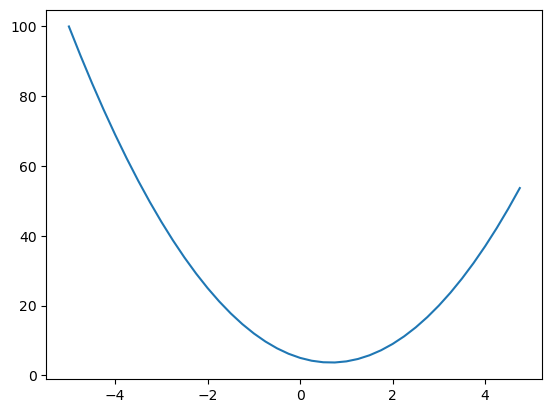

In [ ]:
plt.plot(xs,ys)

In [ ]:
h = 0.001
x = 3.0
(f(x+h)- f(x))/h

14.00300000000243

In [ ]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
d2 = (a+h)*b + c
slope = (d2-d1)/h
slope

-3.000000000010772

### Let's engine file

In [ ]:
class Value:
    
    def __init__(self, data, _prev=(), _op='', label=''):
        self.data = data
        self._prev = set(_prev) # the order does not matter, use set instead of list
        self._op = _op
        self.label = label

        self.grad = 1.0
    
    def __repr__(self) -> str:
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b;        e.label = 'e'
d = e + c;      d.label = 'd'
f = Value(-2.0, label='f')
L = d*f;        L.label='L'
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [ ]:
d._op

'add'

In [ ]:
L.grad = 1.0
# For Mul: child.grad = other.data * out.grad
# For Add: child.grad = out.grad
f.grad = d.data * L.grad
d.grad = f.data * L.grad
c.grad = d.grad
e.grad = d.grad
a.grad = b.data * e.grad
b.grad = a.data * e.grad

In [ ]:
from graphviz import Digraph

def trace(root):
    '''
    Build a set of all nodes and edges in a graph
    '''
    nodes, edges = set(), set()
    
    def build(v): # a heuristic function
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v)) # define edge like this
                build(child)

    build(root)
    return nodes, edges

In [ ]:
# first have an scheme of your desired graph based on the nodes and operations
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR : left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular (record') node for it
        # a visual node
        dot.node(name=uid, label=f'{n.label} | data: {n.data} | grad: {n.grad}', shape='record')
        if n._op:
            # if this value is result of some operation, create an operation node for it
            dot.node(name=uid+n._op , label=n._op) # n._op is a string
            # and connect the op node to the value node
            dot.edge(uid+n._op , uid)
            for child in n._prev:
                dot.edge( str(id(child)) , uid+n._op)
    return dot

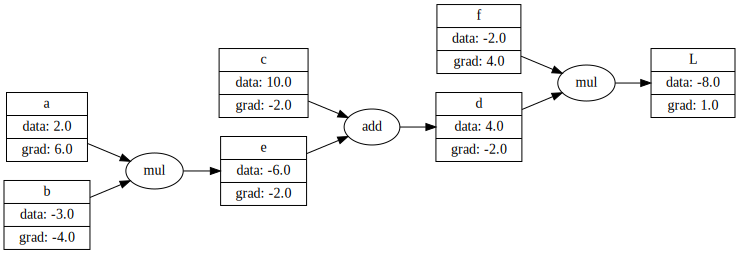

In [ ]:
draw_dot(L)

In [ ]:
# we don't wanna polute or mess up the global variable scales,
# so to play with data we create a local scale
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;        e.label = 'e'
    d = e + c;      d.label = 'd'
    f = Value(-2.0, label='f')
    L1 = d*f;        L1.label='L1'

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b;        e.label = 'e'
    d = e + c;      d.label = 'd'
    f = Value(-2.0, label='f')
    L2 = d*f;        L2.label='L2'
    
    return (L2.data-L1.data)/h

In [ ]:
lol()

6.000000000021544